In [1]:
from wholeslidedata.iterators import create_batch_iterator
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from multiprocessing import process
import torch.optim as optim
import sys
import cv2
import albumentations as A

In [2]:
# function to perform center crop for concatenating skip connections and the hook connection
def center_crop(x, size):
    transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(size=size)])
    return transform(x)

# define the conv-batchnorm-relu-conv-batchnorm-relu block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.conv(x)

# define the HookeNet model
class HookNet(nn.Module):
    def __init__(self, in_channels, out_channels, hook_crop) -> None:
        
        super(HookNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2)
        self.preskips_context = nn.ModuleList()
        self.preskips_target = nn.ModuleList()
        self.hook_crop = hook_crop
        
        # channel sizes for DoubleConv blocks
        features=[32, 64, 128, 256]
        
        # encoder
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # bottleneck
        self.bottleneck = DoubleConv(256, 320)
        
        # decoder
        for feature in reversed(features):
            self.decoder.append(DoubleConv(feature*2, feature))
        
        self.preskips_context.append(nn.Conv2d(320, 256, 3))
        self.preskips_context.append(nn.Conv2d(256, 128, 3))
        self.preskips_context.append(nn.Conv2d(128, 64, 3))
        self.preskips_context.append(nn.Conv2d(64, 32, 3))
        
        self.preskips_target.append(nn.Conv2d(352, 256, 3))
        self.preskips_target.append(nn.Conv2d(256, 128, 3))
        self.preskips_target.append(nn.Conv2d(128, 64, 3))
        self.preskips_target.append(nn.Conv2d(64, 32, 3))
        
        # final conv
        self.finalconv = nn.Conv2d(32, out_channels, 1)
        
    def context_forward(self, x):
        
        # store skip connection inputs
        skip_connections = []
        
        # apply encoder DoubleConvs
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.maxpool(x)
        
        # reverse the skip connections
        skip_connections.reverse()
        
        # apply bottleneck
        x = self.bottleneck(x)
        
        # apply decoder DoubleConvs
        for decode, preskipconv, skip in zip(self.decoder, self.preskips_context, skip_connections):
            x = self.upsample(x)
            x = preskipconv(x)
            x = F.relu(torch.cat((center_crop(skip, (x.shape[2], x.shape[2])), x), dim=1))
            x = decode(x)
        
        # hook out to target branch
        hook = center_crop(x, (self.hook_crop, self.hook_crop))
        
        # final conv
        x = self.finalconv(x)
        
        # return x and hool
        return (hook, x)
    
    def target_forward(self, hook, x):
        
        # store skip connection inputs
        skip_connections = []
        
        # apply encoder DoubleConvs
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.maxpool(x)
        
        # reverse the skip connections
        skip_connections.reverse()
        
        # apply bottleneck
        x = self.bottleneck(x)
        
        # hook in from context branch
        x = torch.cat((hook, x), dim=1)
        
        # apply decoder DoubleConvs
        for decode, preskipconv, skip in zip(self.decoder, self.preskips_target, skip_connections):
            x = self.upsample(x)
            x = preskipconv(x)
            x = F.relu(torch.cat((center_crop(skip, (x.shape[2], x.shape[2])), x), dim=1))
            x = decode(x)
        
        # final conv
        x = self.finalconv(x)
        
        # return x
        return x
    
    def forward(self, context_input, target_input):
        
        # forward pass of context branch
        hook, context_output = self.context_forward(context_input)
        # forward pass of target branch
        target_output = self.target_forward(hook, target_input)
        # return the outputs
        return (context_output, target_output)

In [3]:
# batch iterator config
user_config = '/code/seg/user_config_seg.yml'
# number of cpus used to extract patches on multiple cores
cpus = 1
# create iterators for the dataset
training_iterator = create_batch_iterator(user_config=user_config, mode='training', cpus=cpus, buffer_dtype=np.uint8)
test_iterator = create_batch_iterator(user_config=user_config, mode='inference', cpus=cpus, buffer_dtype=np.uint8)    

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
#def hooknet parameters for training
net = HookNet(3, 7, 10)
net.load_state_dict(torch.load('/code/seg/weights_100.pth'))
net.to(device)
net.eval()

HookNet(
  (encoder): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (2): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(128, 

In [5]:
def dice_loss(output, target):

    eps = 0.0001

    intersection = output * target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + target
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

tensor(0.9279, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2476.7634)
tensor(2593.1055)
tensor(1547.8193)
tensor(343.0689)
tensor(1257.7310)
tensor(351.4748)
tensor(1176.6846)


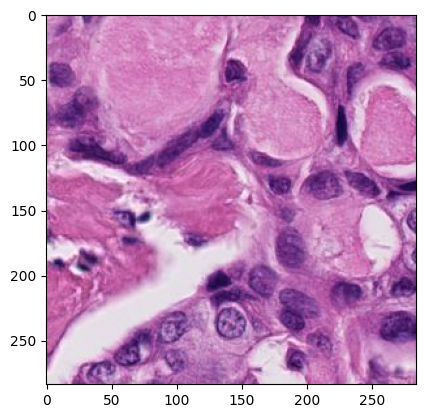

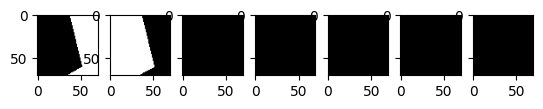

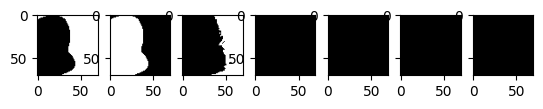

In [41]:
# get input data and true masks
x_batch, y_batch, _ = next(test_iterator)
# convert images to tensors
x_batch_in = torch.from_numpy(x_batch).type(torch.FloatTensor).permute((0,1,4,2,3)).to(device)/255
y_batch_in = torch.from_numpy(y_batch).type(torch.FloatTensor).permute((0,1,4,2,3)).to(device)
context_out, target_out = net(x_batch_in[:,1,:,:,:].squeeze(), x_batch_in[:,0,:,:,:].squeeze())


dice = dice_loss(target_out, y_batch_in[:,0,:,:,:].squeeze())
print(dice)

context_out = context_out.detach().cpu()
target_out = target_out.detach().cpu()

target_out = torch.sigmoid(target_out)

print(torch.sum(target_out[0,0,:,:]))
print(torch.sum(target_out[0,1,:,:]))
print(torch.sum(target_out[0,2,:,:]))
print(torch.sum(target_out[0,3,:,:]))
print(torch.sum(target_out[0,4,:,:]))
print(torch.sum(target_out[0,5,:,:]))
print(torch.sum(target_out[0,6,:,:]))


context_out[context_out >= 0.5] = 1
context_out[context_out < 0.5] = 0
target_out[target_out >= 0.5] = 1
target_out[target_out < 0.5] = 0

context_out = context_out.numpy().astype(np.uint8)
target_out = target_out.numpy().astype(np.uint8)

plt.imshow(x_batch[0,0,:,:,:])
plt.show()

fig, axes = plt.subplots(1, 7)
for i in range(7):
    axes[i].imshow(y_batch[0,0,:,:,i], cmap='gray', vmax=1, vmin=0)
plt.show()

fig, axes = plt.subplots(1, 7)
for i in range(7):
    axes[i].imshow(target_out[0,i,:,:], cmap='gray', vmax=1, vmin=0)
plt.show()

del x_batch_in
del y_batch_in
del context_out
del target_out
del dice
torch.cuda.empty_cache()

In [7]:
del x_batch_in
del y_batch_in
del context_out
del target_out

NameError: name 'x_batch_in' is not defined